In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from shutil import copyfile, copy

In [2]:
import skimage.io
import glob
import tqdm

from glob import glob
from tqdm import tqdm
from skimage.io import imread, imshow
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

In [3]:
# Instantiating the model for loading the weights and biases and preprocess_input

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [4]:
# Reading CSV FILE

data = pd.read_csv('/content/drive/MyDrive/Transfer-Learning/Dataset/train.csv')
print("Data Imported Successfully")

Data Imported Successfully


In [5]:
data.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [6]:
data.shape

(1646, 2)

Target distribution of classes :
0    965
1    681
Name: emergency_or_not, dtype: int64




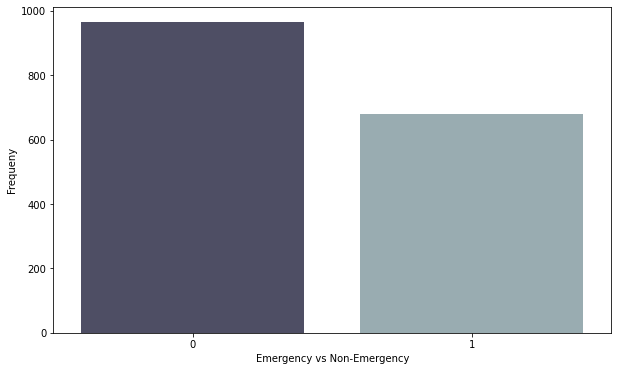

In [7]:
# Checking Target Distribution 

print("Target distribution of classes :")
print(data.emergency_or_not.value_counts())

print("\n")

plt.figure(figsize = (10,6))
sns.countplot(x = data.emergency_or_not, data = data, palette='bone')
plt.xlabel("Emergency vs Non-Emergency")
plt.ylabel("Frequeny")
plt.show()

In [8]:
# Loading Images & Storing 

X = []

for image_name in data.image_names:
  img = imread('/content/drive/MyDrive/Transfer-Learning/Dataset/images/' + image_name)
  X.append(img)

X = np.array(X)

y = data.emergency_or_not.values

In [9]:
# Shuffling Data 

X, y = shuffle(X, y, random_state = 42)

100%|██████████| 5/5 [00:00<00:00, 519.97it/s]


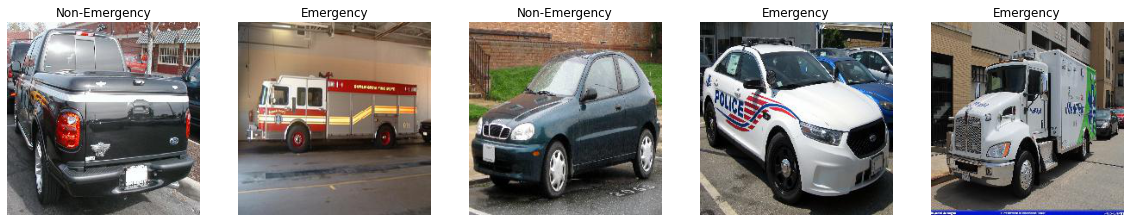

In [10]:
# Viewing Data - After Shuffle

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0,5)):
  rand = np.random.randint(len(X))
  ax[i].imshow(X[rand])
  ax[i].axis('off')
  if y[rand] == 1:
    ax[i].set_title("Emergency")
  else:
    ax[i].set_title("Non-Emergency")

In [11]:
# Preprocess Data

X = preprocess_input(X)

In [12]:
# Converting target label to categorical since we are including 2 neuron at output layer. 

y = to_categorical(y)

In [13]:
# Splitting Data - Training & Validation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [14]:
# Creating train augmentation object

train_datagen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'nearest')

In [15]:
# Applying train augmentation object on training data

train_datagen.fit(X_train)

In [16]:
# Checking Shape - Train & Test

X_train.shape, X_test.shape

((1152, 224, 224, 3), (494, 224, 224, 3))

In [17]:
# Creating model with pre trained imagenet weights

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
# We dont want to train all layers so, we do following step because we are using same weights given in VGG16

for layers in vgg16.layers:
    layers.trainable = False

In [20]:
# Introducing Flatten Layer

x = Flatten()(vgg16.output)

In [21]:
# Introducing FCC & Output Layer

fcc_layer   = Dense(units = 1024, activation = 'relu')(x)
final_layer = Dense(units = 2, activation = 'softmax')(fcc_layer)

In [22]:
# Creating Final Model

model = Model(inputs = vgg16.input, outputs = final_layer)

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [24]:
# Model Compile 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [25]:
# Defining Callbacks

filepath = '/content/drive/MyDrive/Transfer-Learning/Vgg16_Model.h5'

earlystopping   = EarlyStopping(monitor = 'val_accuracy', mode='max', patience = 10, verbose = 1)
modelcheckpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only=True)
learning_rate   = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5, factor = 0.2,  min_lr = 0.003, verbose = 1)

callback_list = [earlystopping, modelcheckpoint, learning_rate]

In [26]:
# Fitting Model

model_history = model.fit(train_datagen.flow(X_train, y_train, batch_size=512),  
                          validation_data = (X_test, y_test),
                          epochs = 10,
                          verbose = 1,
                          callbacks = callback_list)

Epoch 1/10


ResourceExhaustedError: ignored

## **Importing Libraries**

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from keras.utils import to_categorical
from tqdm import tqdm

# Viewing Dataset

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Transfer-Learning/Dataset/train.csv')

In [3]:
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [4]:
train.shape

(1646, 2)

Target distribution of classes :
0    965
1    681
Name: emergency_or_not, dtype: int64




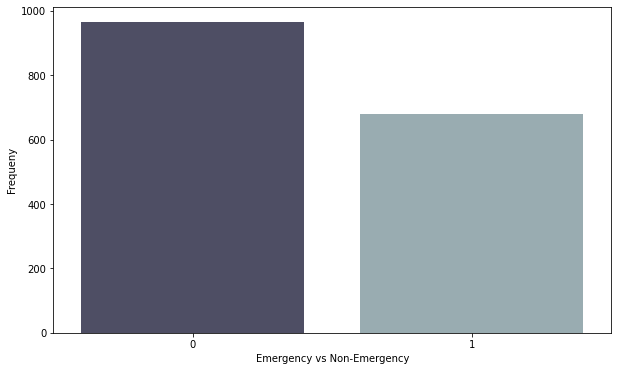

In [7]:
# Checking Target Distribution 

print("Target distribution of classes :")
print(train.emergency_or_not.value_counts())

print("\n")

plt.figure(figsize = (10,6))
sns.countplot(x = train.emergency_or_not, data = train, palette='bone')
plt.xlabel("Emergency vs Non-Emergency")
plt.ylabel("Frequeny")
plt.show()

# Generating Data using Inception V3

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-11-24 17:00:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   153MB/s    in 0.5s    

2020-11-24 17:00:41 (153 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [10]:
weights1="inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [11]:

pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(weights1)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 12, 12, 768)


# Building Model

In [13]:
from tensorflow.keras.optimizers import Adam
x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [15]:
train_image = []
for img_name in tqdm(train['image_names']):
    # defining the image path
    image_path = '/content/drive/MyDrive/Transfer-Learning/Dataset/images/' + img_name
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_image.append(img)

# converting the list to numpy array
train_x = np.array(train_image)
train_x.shape

100%|██████████| 1646/1646 [18:10<00:00,  1.51it/s]


(1646, 224, 224, 3)

In [16]:
#Splitting data into training and testing set

train_y = train['emergency_or_not'].values
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(x_train.shape, y_train.shape), (x_val.shape, y_val.shape)


(((1481, 224, 224, 3), (1481,)), ((165, 224, 224, 3), (165,)))

In [17]:
train_datagen.fit(x_train)
#test_datagen.fit(y_train)

# Evaluating Performance

In [ ]:
from keras.callbacks import ModelCheckpoint
batch_size = 32
epochs = 50

history = model.fit(
    x_train, y_train, batch_size=batch_size,
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val))

Epoch 1/50
46/46 [==============================] - 152s 3s/step - loss: 0.3392 - accuracy: 0.8580 - val_loss: 0.1363 - val_accuracy: 0.9394
Epoch 2/50
46/46 [==============================] - 149s 3s/step - loss: 0.0455 - accuracy: 0.9876 - val_loss: 0.1199 - val_accuracy: 0.9455
Epoch 3/50
46/46 [==============================] - 148s 3s/step - loss: 0.0272 - accuracy: 0.9945 - val_loss: 0.1207 - val_accuracy: 0.9515
Epoch 4/50
46/46 [==============================] - 146s 3s/step - loss: 0.0141 - accuracy: 0.9965 - val_loss: 0.1783 - val_accuracy: 0.9273
Epoch 5/50
46/46 [==============================] - 148s 3s/step - loss: 0.0140 - accuracy: 0.9972 - val_loss: 0.1297 - val_accuracy: 0.9455
Epoch 6/50
46/46 [==============================] - 147s 3s/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.1662 - val_accuracy: 0.9333
Epoch 7/50
46/46 [==============================] - 148s 3s/step - loss: 0.0139 - accuracy: 0.9952 - val_loss: 0.1266 - val_accuracy: 0.9455
Epoch 8/50
46

In [ ]:
score = model.evaluate(x_val, y_val)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

6/6 [==============================] - 12s 2s/step - loss: 0.4714 - accuracy: 0.9212
Loss: 0.4714
Accuracy: 0.9212


In [ ]:
# Summarize  Loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor = (1,1))
plt.show()

In [ ]:
# Summarize Accuracy

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()